In [1]:
# Create GAN for MDP process of six sided die

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class GAN:
    def __init__(self, seq_len=100):
        # self.P = np.random.uniform(0, 1, (6, 6))
        self.P = np.array([[0.5,0.5,0,0,0,0],[0,0.5,0.5,0,0,0],[0,0,0.5,0.5,0,0],[0,0,0,0.5,0.5,0],[0,0,0,0,0.5,0.5],[0.5,0,0,0,0,0.5]])
        # print(self.P, np.sum(self.P, axis=1, keepdims=True))
        # self.P = self.P / np.sum(self.P, axis=1, keepdims=True)
        self.seq_len = seq_len
        # print(self.P)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        print(self.P)
    
    def generate_real_samples(self, n_samples):
        X_total = []
        for i in range(n_samples):
            X = [np.random.choice(6)]
            for i in range(1, self.seq_len):
                X.append(np.random.choice(6, p=self.P[X[i - 1]]))
            X = np.array(X)
            X = tf.keras.utils.to_categorical(X, num_classes=6)
            X_total.append(X)
        X = np.array(X_total)
        y = np.ones((n_samples, 1)) * 0.9
        # print(X.shape, y.shape)
        return X, y
    
    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, 25)))
        y = np.zeros((n_samples, 1))
        return X, y
    
    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        X = np.argmax(X, axis=2)
        P = np.zeros((6, 6))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                P[X[i, j], X[i, j + 1]] += 1
                
        P = P / np.sum(P, axis=1, keepdims=True)
        return P
    
    def calculate_P_real(self, n_samples):
        X, _ = self.generate_real_samples(n_samples)
        X = np.argmax(X, axis=2)
        P = np.zeros((6, 6))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                P[X[i, j], X[i, j + 1]] += 1
                
        P = P / np.sum(P, axis=1, keepdims=True)
        return P
    def build_generator(self):
        self.generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(100 * 100, input_shape=(25,)),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Reshape((100, 100)),
            tf.keras.layers.LSTM(50, return_sequences=True),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LSTM(25, return_sequences=True),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(6, activation='softmax'),
            
            
            # tf.keras.layers.LeakyReLU(alpha=0.2),
            # tf.keras.layers.Reshape((25, 200)), 
            # tf.keras.layers.Conv1DTranspose(100, 3, strides=2, padding='same'),
            # tf.keras.layers.LeakyReLU(alpha=0.2),
            # tf.keras.layers.Conv1DTranspose(50, 3, strides=2, padding='same'),
            # tf.keras.layers.LeakyReLU(alpha=0.2),
            # tf.keras.layers.Conv1DTranspose(6, 3, strides=1, padding='same', activation='softmax'),
        ])
    def summarize_generator(self):
        self.generator.summary()
        # tf.keras.utils.plot_model(self.generator, show_shapes=True, dpi=64)

    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True), input_shape=(self.seq_len, 6)),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    def summarize_discriminator(self):
        self.discriminator.summary()
        # tf.keras.utils.plot_model(self.discriminator, show_shapes=True, dpi=64)
    
    def build_gan(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([
            self.generator,
            self.discriminator,
        ])
        self.gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())
        
    def train(self, epochs = 1000, batch_size = 128):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = 100000//batch_size
        train_data_x, train_data_y = self.generate_real_samples(100000)
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator
            
            for k in range(total):
                print(k,"/",total,end="\r")
                idx = np.random.randint(0, 100000, batch_size//2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                # X_real, y_real = self.generate_real_samples(batch_size//2)
                X_fake, y_fake = self.generate_fake_samples(batch_size//2)
                

                # Train the discriminator
                # if l2_hist and l2_hist[-1] < 0.2:
                #     l1, ac1 = self.discriminator.test_on_batch(X_real, y_real)
                #     l2, ac2 = self.discriminator.test_on_batch(X_fake, y_fake)
                # else:
                #     l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                #     l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)
                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)
                
                X_fake = np.random.normal(0, 1, (batch_size, 25))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)
                
                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)
                
            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(100000)
            print(calc_p)
            print("Loss:",np.mean(np.abs(calc_p - self.P)))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

2024-02-01 04:25:06.341386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 04:25:06.341438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 04:25:06.342959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 04:25:06.352021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 04:25:08.088561: W tensorflow/compiler/tf2

In [2]:
gan = GAN()
gan.summarize_generator()
gan.summarize_discriminator()

2024-02-01 04:25:13.636571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2024-02-01 04:25:13.881170: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


[[0.5 0.5 0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.5 0.  0.  0.  0.  0.5]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10000)             260000    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10000)             0         
                                                                 
 reshape (Reshape)           (None, 100, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 50)           30200     
                                                                 
 lstm_1 (LSTM)               (None, 100, 25)           7600      
                                                                 
 dense_1 (Dense)         

Iteration: 0


2024-02-01 04:28:29.757264: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-01 04:28:34.729792: I external/local_xla/xla/service/service.cc:168] XLA service 0x1502ee94c900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 04:28:34.729834: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-02-01 04:28:34.736825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706741914.891945   31536 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


/tmp/ipykernel_31474/3850469690.py:48: RuntimeWarning: invalid value encountered in divide
  P = P / np.sum(P, axis=1, keepdims=True)


[[           nan            nan            nan            nan
             nan            nan]
 [0.00000000e+00 9.77882376e-01 1.13372996e-05 1.99398978e-02
  2.16638910e-03 0.00000000e+00]
 [0.00000000e+00 3.50109409e-02 3.91684902e-01 5.05470460e-01
  2.84463895e-02 3.93873085e-02]
 [0.00000000e+00 1.25963264e-01 9.25754490e-05 5.75021229e-01
  2.98887818e-01 3.51148255e-05]
 [0.00000000e+00 1.40323166e-03 4.23214376e-06 7.46918171e-03
  9.91106978e-01 1.63765563e-05]
 [0.00000000e+00 6.69353512e-01 2.82941273e-02 7.99473598e-02
  1.31600592e-03 2.21088995e-01]]
Loss: nan


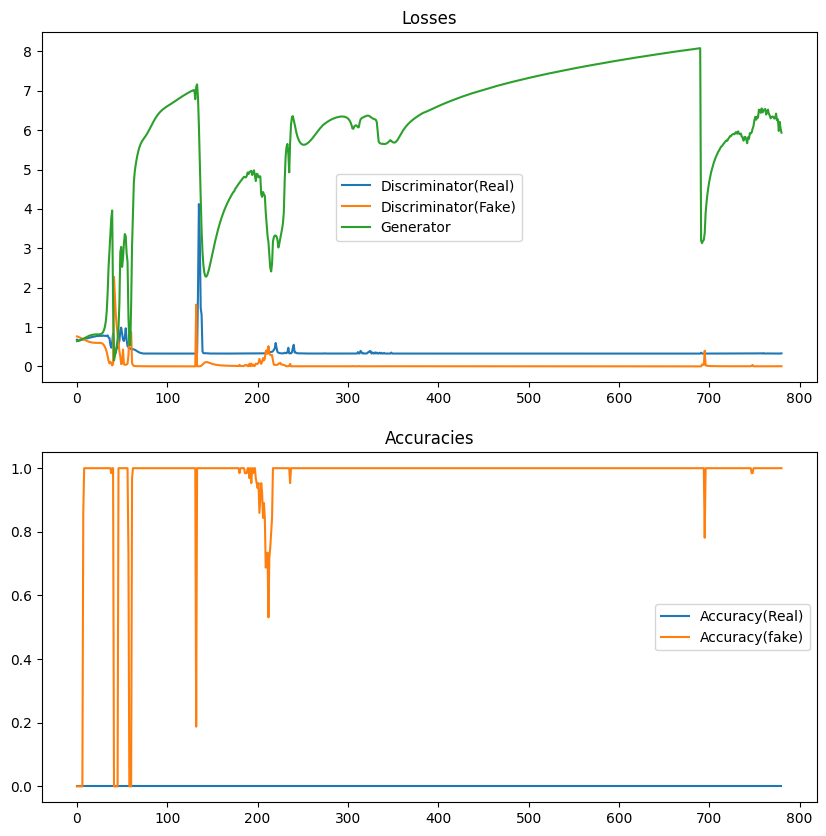

Iteration: 1
[[3.92631520e-01 6.06164935e-01 7.91547604e-04 3.71865136e-04
  3.79977005e-05 2.13470228e-06]
 [2.53435192e-04 2.85876390e-01 6.42617542e-01 7.12167827e-02
  3.58493788e-05 0.00000000e+00]
 [2.61869495e-04 8.96456653e-04 4.83833650e-02 9.49121435e-01
  1.33389774e-03 2.97578972e-06]
 [1.17874111e-02 2.02650075e-03 3.83297140e-04 1.58495415e-01
  7.55995967e-01 7.13114087e-02]
 [1.77535528e-01 2.90978380e-03 2.96064618e-05 1.83711891e-04
  2.88814831e-02 7.90459887e-01]
 [9.76592662e-01 5.08892040e-06 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.34022486e-02]]
Loss: 0.1145738654169305


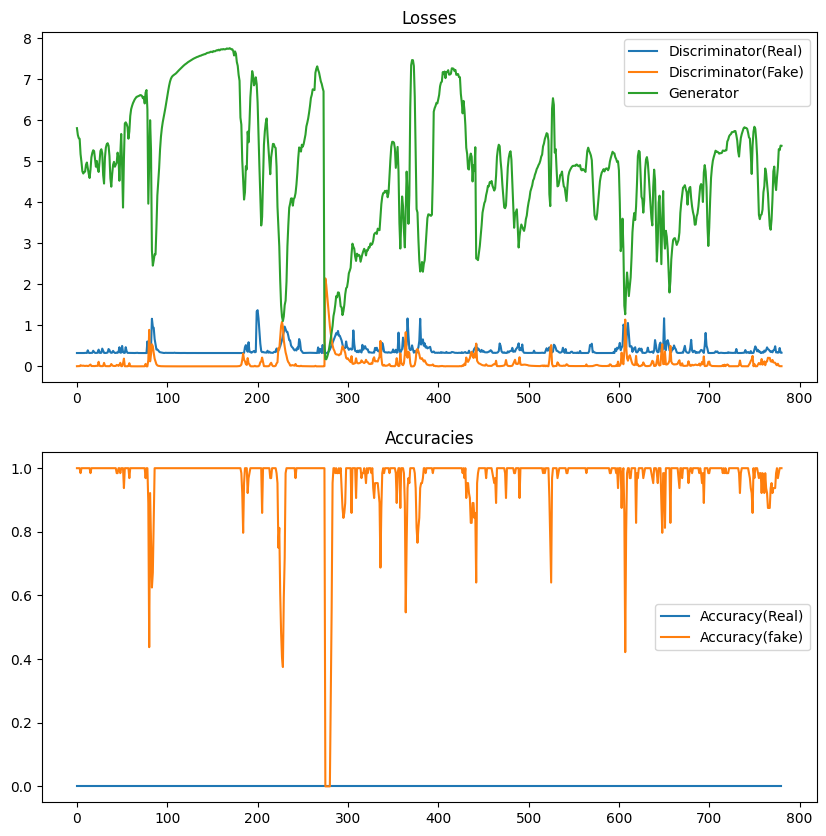

Iteration: 2
[[2.28522213e-01 7.48170463e-01 2.14252517e-02 1.53388113e-06
  6.61869709e-04 1.21866856e-03]
 [3.38910247e-04 1.53870584e-01 8.35579788e-01 9.02948291e-03
  1.18123549e-03 0.00000000e+00]
 [1.93653214e-04 1.06706873e-04 4.44005816e-01 5.49498404e-01
  5.64953610e-03 5.45884696e-04]
 [9.76431983e-06 6.71296989e-06 9.40426054e-04 3.21978446e-01
  6.61702324e-01 1.53623264e-02]
 [1.42498860e-04 3.41066659e-03 2.70398857e-03 6.16525680e-05
  3.50026057e-01 6.43655136e-01]
 [5.33130309e-01 5.31969291e-02 3.18267279e-04 0.00000000e+00
  1.82438169e-03 4.11530113e-01]]
Loss: 0.060559265072623054


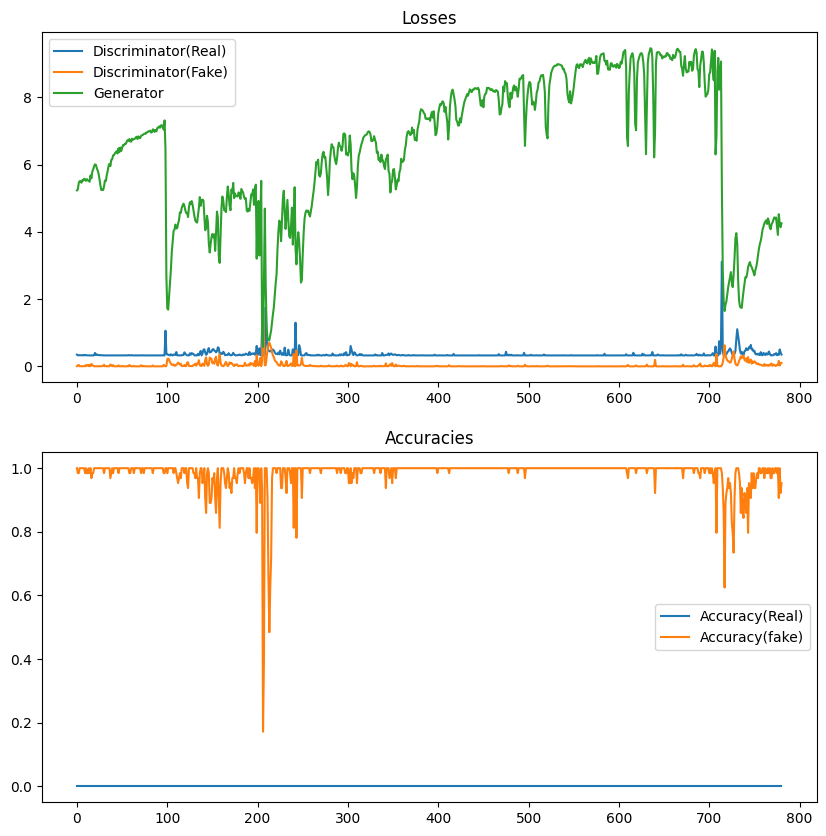

Iteration: 3
[[5.03087806e-01 4.92334216e-01 2.80736088e-03 1.98029605e-05
  1.37222868e-03 3.78586010e-04]
 [9.97903861e-04 4.89929342e-01 5.08391464e-01 1.09342867e-04
  5.71947306e-04 0.00000000e+00]
 [4.45717047e-04 1.37721560e-05 4.63147589e-01 5.29396041e-01
  6.98874314e-03 8.13809216e-06]
 [1.13840760e-05 1.89734599e-06 3.03575359e-05 4.77246394e-01
  5.22657473e-01 5.24932391e-05]
 [1.46027874e-02 8.26999450e-05 4.52172361e-04 6.96107450e-05
  4.88557362e-01 4.96235368e-01]
 [4.99764048e-01 3.74267963e-04 0.00000000e+00 0.00000000e+00
  7.65411131e-05 4.99785142e-01]]
Loss: 0.005166696612781476


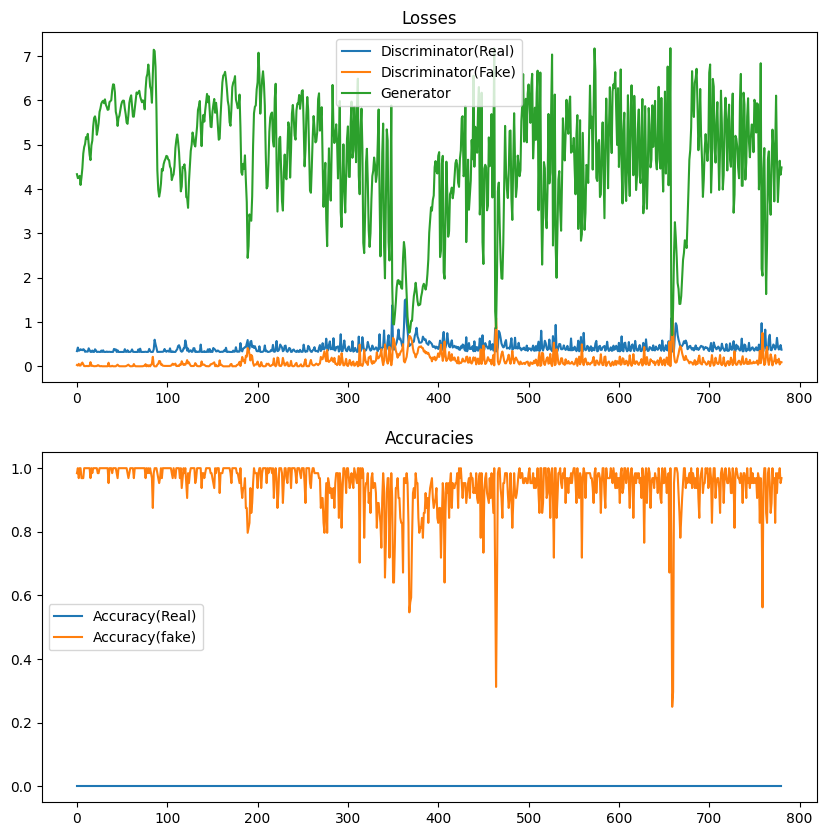

Iteration: 4
[[5.51143399e-01 4.44847048e-01 3.37436436e-03 0.00000000e+00
  8.93792433e-05 5.45809246e-04]
 [5.17810281e-04 4.78125673e-01 5.18783418e-01 1.10342114e-04
  2.45743852e-03 5.31769223e-06]
 [2.47221354e-04 4.63921553e-05 5.15066463e-01 4.75646560e-01
  8.95795894e-03 3.54045396e-05]
 [2.34565447e-05 3.51848170e-06 5.57092937e-05 5.54445279e-01
  4.45321328e-01 1.50708300e-04]
 [1.93714598e-04 9.11223276e-04 3.77870911e-04 2.23026676e-05
  5.08753797e-01 4.89741092e-01]
 [4.11172832e-01 1.98782181e-02 1.09169217e-04 0.00000000e+00
  1.19975307e-03 5.67640028e-01]]
Loss: 0.014174748150819486


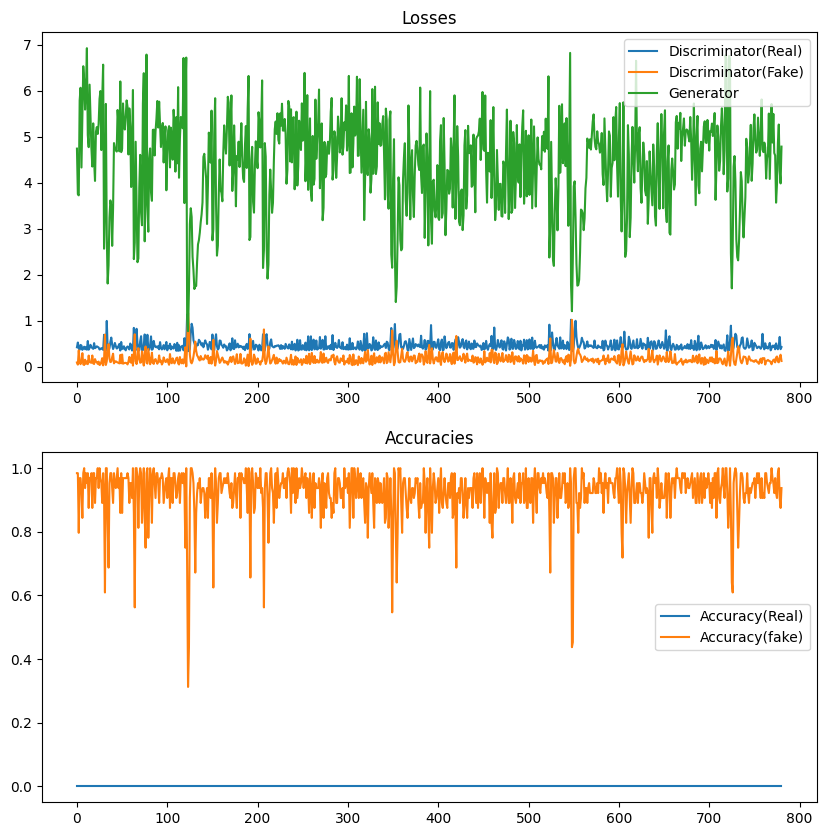

Iteration: 5
[[4.99838096e-01 4.94298805e-01 4.42840095e-03 6.79146798e-05
  6.55497936e-04 7.11284994e-04]
 [7.17239607e-04 5.65446534e-01 4.33565550e-01 1.37971202e-04
  1.32705126e-04 0.00000000e+00]
 [6.95191907e-04 5.29552737e-04 4.88158954e-01 5.00136698e-01
  1.02172890e-02 2.62313333e-04]
 [1.72717183e-04 9.29138643e-05 3.17503205e-04 5.35709420e-01
  4.59680228e-01 4.02721749e-03]
 [6.66619300e-03 6.96571891e-06 1.95040130e-05 1.11451503e-05
  4.26456636e-01 5.66839556e-01]
 [5.27284171e-01 3.88492053e-03 5.20156723e-06 1.75552894e-05
  9.25878967e-04 4.67882273e-01]]
Loss: 0.012784414276626214


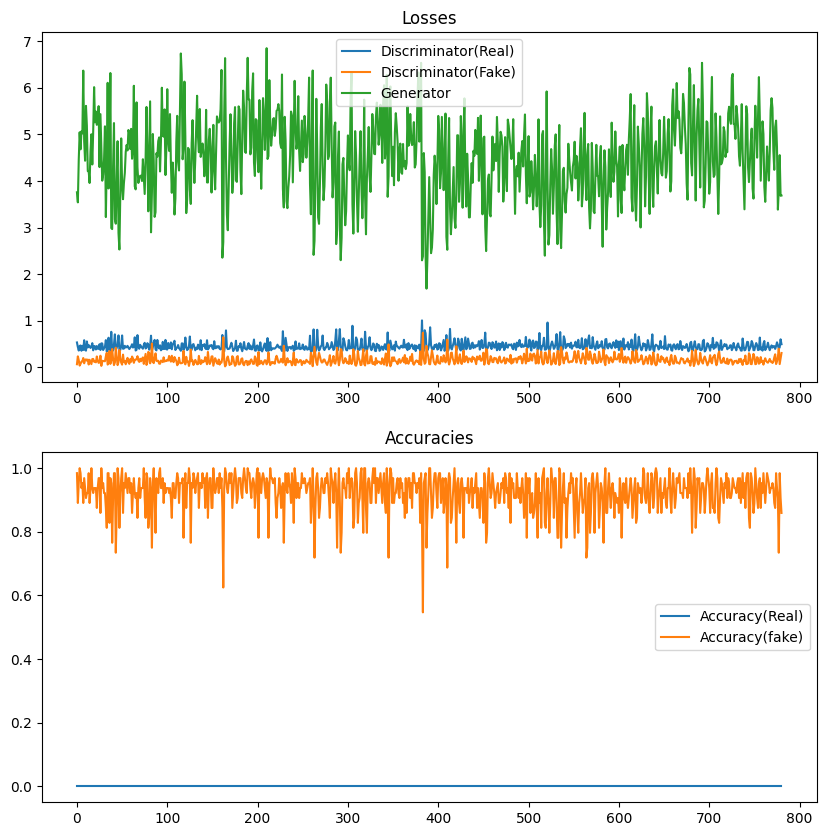

Iteration: 6
[[5.37650529e-01 4.59447307e-01 2.17111555e-03 1.35194003e-05
  1.03148017e-04 6.14381638e-04]
 [2.96665466e-03 4.58143964e-01 5.38516273e-01 3.20227132e-04
  4.34803812e-05 9.40116351e-06]
 [1.95368675e-03 1.86482966e-04 4.64227423e-01 5.12844526e-01
  1.99788146e-02 8.09067164e-04]
 [1.53502631e-04 5.61594990e-05 3.55676827e-04 3.41165212e-01
  6.46944699e-01 1.13247502e-02]
 [3.30970451e-03 4.93558701e-05 3.64804257e-05 2.86120986e-06
  3.58956660e-01 6.37644938e-01]
 [5.14097683e-01 2.00927911e-03 4.55360705e-06 1.36608212e-05
  7.35407539e-04 4.83139416e-01]]
Loss: 0.024162223261584428


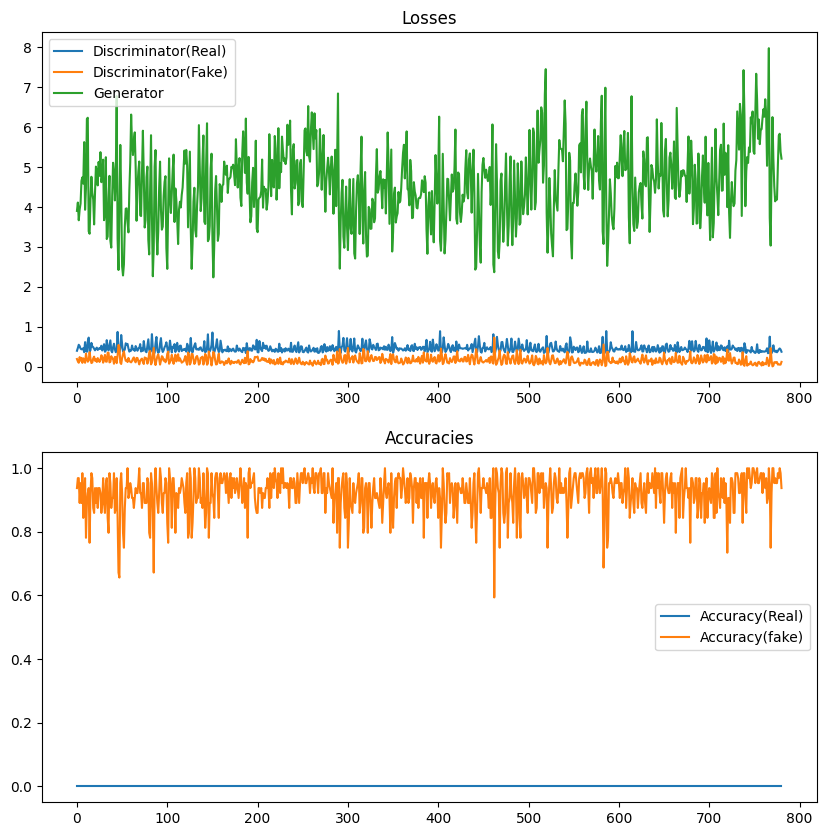

Iteration: 7
[[4.66443064e-01 5.26110952e-01 4.76473191e-03 9.24569654e-05
  7.06510773e-04 1.88228426e-03]
 [1.20942182e-03 4.14670948e-01 5.83855191e-01 2.08051664e-04
  5.50915622e-05 1.29627205e-06]
 [2.33153685e-03 8.51326765e-05 3.80581511e-01 6.03744465e-01
  1.31481926e-02 1.09162061e-04]
 [5.06019838e-04 1.24024470e-04 5.47568035e-04 4.53027282e-01
  5.38361079e-01 7.43402673e-03]
 [6.25821723e-03 4.59329641e-05 5.42844121e-05 1.72994280e-05
  4.64704991e-01 5.28919275e-01]
 [4.73691583e-01 8.82180068e-04 1.58570414e-06 1.21570651e-05
  5.27510910e-04 5.24884984e-01]]
Loss: 0.019271145601261225


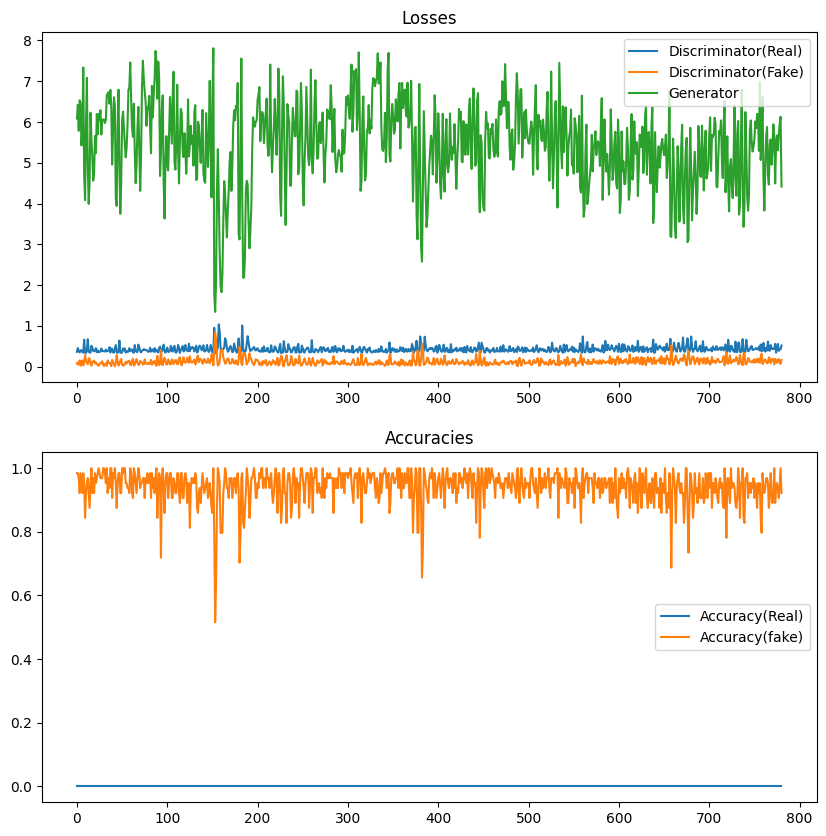

Iteration: 8
[[4.92607605e-01 5.02363253e-01 3.26356723e-03 3.44701874e-05
  1.43314186e-03 2.97962637e-04]
 [8.78844051e-04 4.38766298e-01 5.60103853e-01 4.73473179e-05
  2.03658326e-04 0.00000000e+00]
 [1.30117100e-03 3.78586010e-05 4.94103086e-01 4.99731786e-01
  4.77775545e-03 4.83425213e-05]
 [3.52758687e-04 5.08578474e-05 4.43112522e-04 5.40541008e-01
  4.52445478e-01 6.16678452e-03]
 [8.99272714e-03 7.44284309e-04 5.25127184e-04 1.09882104e-04
  4.78020544e-01 5.11607436e-01]
 [5.91618473e-01 3.03384434e-03 3.48637594e-06 6.27547669e-06
  1.55143729e-03 4.03786483e-01]]
Loss: 0.013363262210661064


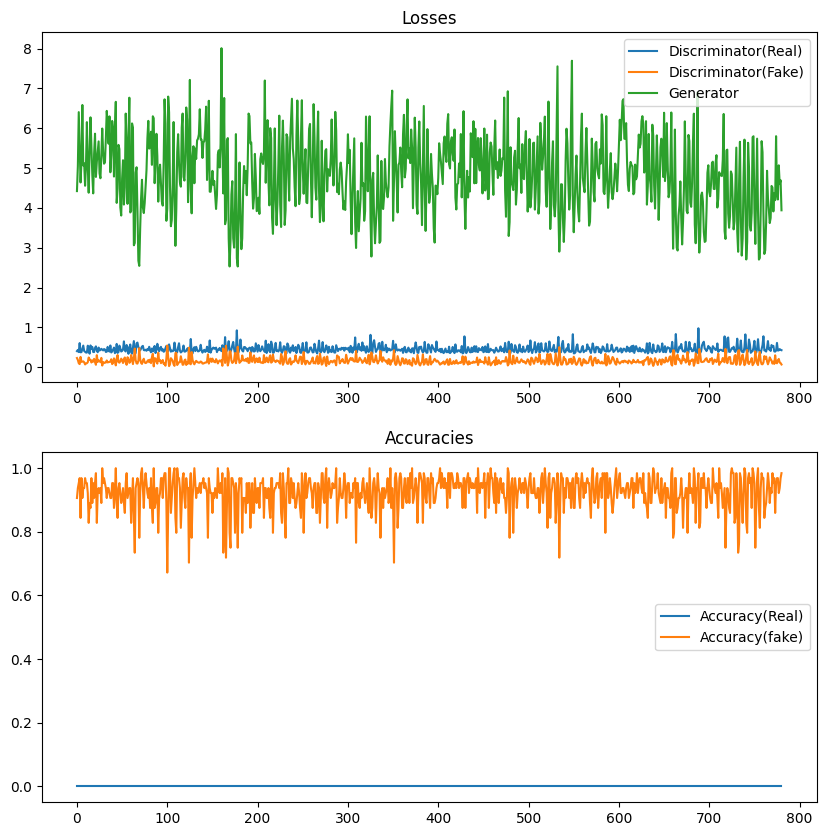

Iteration: 9
[[4.85898313e-01 5.07115304e-01 4.56630403e-03 1.60080772e-05
  1.55507036e-03 8.48999810e-04]
 [2.26617572e-03 4.40270307e-01 5.57219052e-01 2.63947256e-05
  2.18070709e-04 0.00000000e+00]
 [3.63192654e-03 6.28403215e-05 4.49805531e-01 5.31675488e-01
  1.47223281e-02 1.01886735e-04]
 [1.02476656e-03 3.98766482e-05 3.82942416e-04 4.51325171e-01
  5.40509611e-01 6.71763282e-03]
 [7.92118810e-03 5.40859475e-04 5.09921650e-04 9.88905475e-05
  5.09701218e-01 4.81227922e-01]
 [5.71731062e-01 3.30779478e-03 1.95998111e-05 2.54797544e-05
  2.40555014e-03 4.22510514e-01]]
Loss: 0.014942346803758536


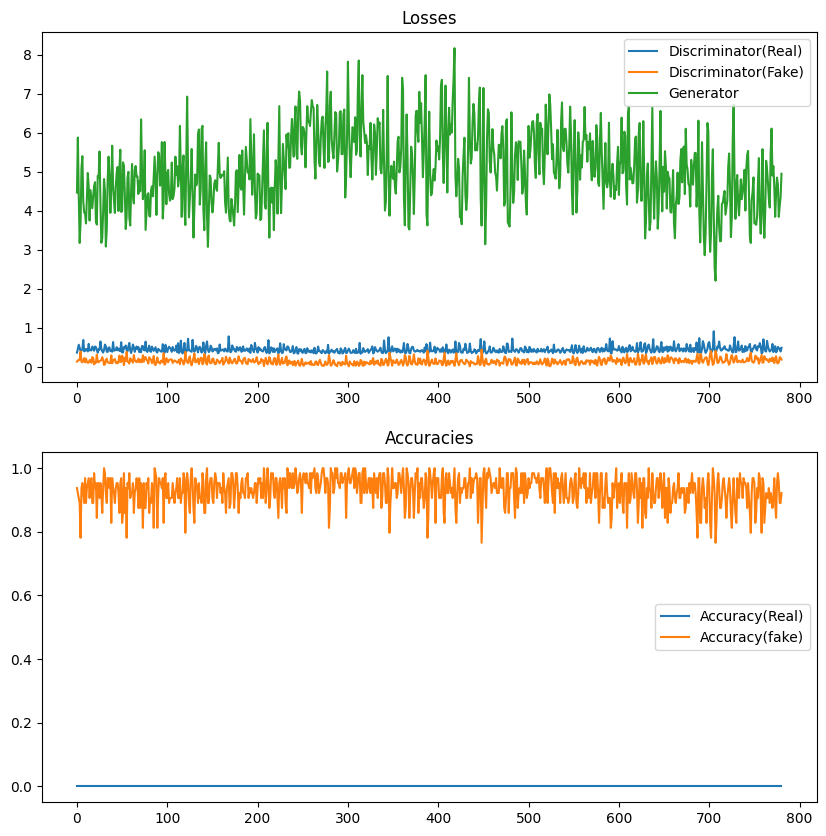

In [3]:
tf.keras.utils.disable_interactive_logging()
gan.train(10, 128)

In [9]:
print(np.argmax(gan.generator.predict(np.random.normal(0, 1, (1, 25))), axis=2))
print(np.argmax(gan.generate_real_samples(1)[0], axis=2))
# print()

[[0 1 1 2 2 3 4 4 5 0 0 0 1 2 3 3 4 5 0 0 0 0 0 1 1 1 2 3 3 4 4 4 4 5 0 0
  1 1 2 2 3 4 5 0 0 0 0 1 1 1 2 3 4 5 5 0 1 2 2 3 3 4 4 5 5 5 0 0 0 1 2 2
  3 4 5 0 1 2 3 4 5 0 1 2 2 3 3 4 4 5 0 1 2 4 0 1 0 0 0 1]]
[[0 0 1 1 2 3 3 3 4 5 0 0 0 1 2 3 4 5 5 5 0 1 1 2 3 4 4 5 5 5 0 1 2 3 3 3
  3 4 5 5 0 0 0 1 1 1 2 3 4 4 5 0 0 1 1 1 2 2 2 2 3 4 5 0 0 1 2 3 3 4 4 5
  5 0 0 0 1 1 1 2 2 2 3 3 4 5 0 0 1 2 2 3 3 3 4 4 5 5 5 5]]


In [7]:
print(gan.discriminator.predict(gan.generator.predict(np.random.normal(0, 1, (1, 25)))))

[[0.23151068]]


In [10]:
print(gan.calculate_P(1000))

[[4.82071257e-01 5.10654141e-01 4.69698705e-03 0.00000000e+00
  1.54656891e-03 1.03104594e-03]
 [2.54825763e-03 4.30337007e-01 5.66605084e-01 1.27412881e-04
  3.82238644e-04 0.00000000e+00]
 [3.71475550e-03 0.00000000e+00 4.50337982e-01 5.32549784e-01
  1.32756836e-02 1.21795262e-04]
 [9.48406677e-04 0.00000000e+00 1.89681335e-04 4.49291856e-01
  5.42425392e-01 7.14466363e-03]
 [7.86362387e-03 6.04894144e-04 4.94913390e-04 1.64971130e-04
  5.10310696e-01 4.80560902e-01]
 [5.69344486e-01 3.11223497e-03 0.00000000e+00 6.48382286e-05
  2.85288206e-03 4.24625559e-01]]
